# Modeling

### 1. Load Data

In [175]:
#import relevant packages
import numpy as np
import pandas as pd
from io import StringIO
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [176]:
#get path extention
numeric = '1xvv81F7_NoHaf0qObgWcMWZDLi_w2S0_'
text = '1Jy7ngEMFjZxdEQ6ax5HeTODChFTCZBtY'
target = '1KQNJU82wtbl5pU_2ko5q_-8vVCt0GTqj'

#set file path
download = 'https://drive.google.com/uc?export=download&id='
path_numeric = download + numeric
path_text = download + text
path_target = download + target

#get raw data
raw_numeric = StringIO(requests.get(path_numeric).text)
raw_text = StringIO(requests.get(path_text).text)
raw_target = StringIO(requests.get(path_target).text)

In [177]:
#load into DataFrames
data_numeric = pd.read_csv(raw_numeric)
data_text = pd.read_csv(raw_text)
data_target = pd.read_csv(raw_target)

In [178]:
#specify text features
titles = data_text.title
short_titles = data_text.short_title
print(titles.shape)
print(short_titles.shape)

(18013,)
(18013,)


In [179]:
#reshape data to reflect different target variables for each stage of passage
X_num = {}
X_text = {}
y = {}
data_target.loc[data_target.active == 0, 'active'] = np.nan
stages = ['active', 'house_passage', 'senate_passage', 'enacted']
for i in range(4):
    if i == 0:
        
        X_num['stage'+str(1)] = data_numeric.drop(columns = 'bill_id')
        X_text['stage'+str(1)] = titles
        X_text['short_stage'+str(1)] = short_titles
        y['stage'+str(1)] = pd.get_dummies(data_target[stages[0]].notnull(), drop_first = True).values
       
              
    else: 
        
        mask = pd.get_dummies(data_target[stages[i-1]].notnull(), drop_first = True).values.reshape(18013)
        X_num['stage'+str(i+1)] = X_num['stage1'][mask == 1]
        X_text['stage'+str(i+1)] = X_text['stage1'][mask == 1]
        X_text['short_stage'+str(i+1)] = X_text['short_stage1'][mask == 1]
        y['stage'+str(i+1)] = pd.get_dummies(data_target[stages[i]].notnull(), drop_first = True).values[mask == 1]
        


In [180]:
for i in range(4):
    print(X_num['stage'+str(i+1)].shape)

(18013, 18)
(3991, 18)
(2112, 18)
(636, 18)


In [181]:
#create beginning to end data
X_0 = X_num['stage1']
y_0 = pd.get_dummies(data_target['enacted'].notnull(), drop_first = True).values
assert(X_0.shape[0] == y_0.shape[0])

### 2. Train-Test Split and Standardization/Vectorization

In [182]:
#perform train/test splits and scale
#the same random state will be used for all to ensure that the same bills are trained on for each
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words= 'english', ngram_range = (1,3), max_df = .9)
for i in range(4):
    X_num['train'+str(i+1)], X_num['test'+str(i+1)], y['train'+str(i+1)], y['test'+str(i+1)] = train_test_split(X_num['stage'+str(i+1)], y['stage'+str(i+1)], stratify = y['stage'+str(i+1)], test_size = 0.2, random_state = 42)
    
    X_text['train'+str(i+1)], X_text['test'+str(i+1)], _, _ = train_test_split(X_text['stage'+str(i+1)], y['stage'+str(i+1)], stratify = y['stage'+str(i+1)], test_size = 0.2, random_state = 42)
    
    X_text['short_train'+str(i+1)], X_text['short_test'+str(i+1)], _, _ = train_test_split(X_text['short_stage'+str(i+1)], y['stage'+str(i+1)], stratify = y['stage'+str(i+1)], test_size = 0.2, random_state = 42)
    
    scaler = StandardScaler()
    X_num['train'+str(i+1)] = scaler.fit_transform(X_num['train'+str(i+1)])
    X_num['test'+str(i+1)] = scaler.transform(X_num['test'+str(i+1)])
    
    vectorizer = TfidfVectorizer(stop_words= 'english', ngram_range = (1,2), max_df = .9, min_df = 2)
    X_text['train'+str(i+1)] = vectorizer.fit_transform(X_text['train'+str(i+1)])
    X_text['test'+str(i+1)] = vectorizer.transform(X_text['test'+str(i+1)])
    X_text['short_train'+str(i+1)] = vectorizer.fit_transform(X_text['short_train'+str(i+1)])
    X_text['short_test'+str(i+1)] = vectorizer.transform(X_text['short_test'+str(i+1)])
    

In [183]:
#split the end to end data
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, stratify = y_0, test_size = 0.2, random_state = 42)

In [184]:
#examine the number of features in the vectorized text data
for i in range(4):
    print(X_text['train'+str(i+1)].shape)
    print(X_text['short_train'+str(i+1)].shape)

(14410, 39762)
(14410, 17102)
(3192, 9168)
(3192, 3965)
(1689, 5462)
(1689, 2632)
(508, 1425)
(508, 831)


### 3. Get Baseline Performance

Baseline models will be fitted to each dataset and evaluated using five-fold cross validation. Multiple evaluation metrics will be used with this data due to variable class imbalance: at different stages either the positive or the negative outcome may be highly favored, but never is it an even distribution. The evaluation metrics to be used are the F1 score and balanced accuracy. The following models will be fit to each dataset:

1. Logistic Regression
2. Gradient Boosted Classifier
3. Neural Net

In [185]:
#import relevant models, specify evaluation metrics
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
metrics = ('f1', 'balanced_accuracy')

In [186]:
#fit the logistic regression model to each dataset using five fold cross validation and save the scores for each stage
log_reg = LogisticRegression(class_weight = 'balanced', max_iter = 1000)

num_f1 = []
num_train_f1 = []
num_accuracy = []
num_train_accuracy = []

text_f1 = []
text_train_f1 = []
text_accuracy = []
text_train_accuracy = []

short_text_f1 = []
short_text_train_f1 = []
short_text_accuracy = []
short_text_train_accuracy = []

for i in range(4):
    X1 = X_num['train'+str(i+1)]
    X2 = X_text['train'+str(i+1)]
    X3 = X_text['short_train'+str(i+1)]
    Y = np.ravel(y['train'+str(i+1)])
    
    cv1 = cross_validate(log_reg, X1, Y, scoring = metrics, cv = 5, return_train_score = True)
    cv2 = cross_validate(log_reg, X2, Y, scoring = metrics, cv = 5, return_train_score = True)
    cv3 = cross_validate(log_reg, X3, Y, scoring = metrics, cv = 5, return_train_score = True)
    
    num_f1.append(cv1['test_f1'])
    num_train_f1.append(cv1['train_f1'])
    num_accuracy.append(cv1['test_balanced_accuracy'])
    num_train_accuracy.append(cv1['train_balanced_accuracy'])
    
    text_f1.append(cv2['test_f1'])
    text_train_f1.append(cv2['train_f1'])
    text_accuracy.append(cv2['test_balanced_accuracy'])
    text_train_accuracy.append(cv2['train_balanced_accuracy'])
    
    short_text_f1.append(cv3['test_f1'])
    short_text_train_f1.append(cv3['train_f1'])
    short_text_accuracy.append(cv3['test_balanced_accuracy'])
    short_text_train_accuracy.append(cv3['train_balanced_accuracy'])
    

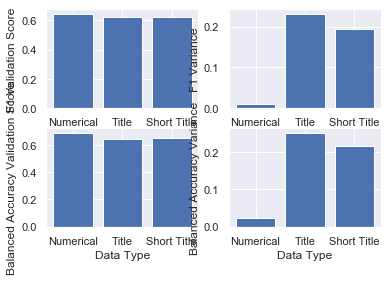

In [187]:
#plot the average performance of the model for each dataset and metric 
#plot the difference between the train and validation score
sns.set()
labels = ['Numerical', 'Title', 'Short Title']
f1_means = [np.mean(num_f1), np.mean(text_f1), np.mean(short_text_f1)]
f1_variance = [np.mean(num_train_f1) - np.mean(num_f1), np.mean(text_train_f1) - np.mean(text_f1),
               np.mean(short_text_train_f1) - np.mean(short_text_f1)]
accuracy_means = [np.mean(num_accuracy), np.mean(text_accuracy), np.mean(short_text_accuracy)]
accuracy_variance = [np.mean(num_train_accuracy) - np.mean(num_accuracy), np.mean(text_train_accuracy) - np.mean(text_accuracy), 
                     np.mean(short_text_train_accuracy) - np.mean(short_text_accuracy)]

ax1 = plt.subplot(221)
ax1.bar(labels, f1_means)
plt.xlabel('Data Type')
plt.ylabel('F1 Score')

ax2 = plt.subplot(222)
ax2.bar(labels, f1_variance)
plt.xlabel('Data Type')
plt.ylabel('F1 Variance')

ax3 = plt.subplot(223)
ax3.bar(labels, accuracy_means)
plt.xlabel('Data Type')
plt.ylabel('Accuracy Score')

ax4 = plt.subplot(224)
ax4.bar(labels, accuracy_variance)
plt.xlabel('Data Type')
plt.ylabel('Accuracy Variance')

plt.show()

In [192]:
#print the average performance for each stage
for i in range(4):
    print('Stage '+ str(i+1)+':')
    print()
    print('Numerical Train F1: ', np.mean(num_train_f1[i]))
    print('Numerical Test F1: ', np.mean(num_f1[i]))
    print('Title Train F1: ', np.mean(text_train_f1[i]))
    print('Title Test F1: ', np.mean(text_f1[i]))
    print('Short Title Train F1: ', np.mean(short_text_train_f1[i]))
    print('Short title Test F1: ', np.mean(short_text_f1[i]))
    print()
    print()

Stage 1:

Numerical Train F1:  0.569671582569389
Numerical Test F1:  0.5676443995831516
Title Train F1:  0.7385192409003899
Title Test F1:  0.4591768849272369
Short Title Train F1:  0.7147716143179206
Short title Test F1:  0.4640312161328074


Stage 2:

Numerical Train F1:  0.7278518168036479
Numerical Test F1:  0.7193651944057663
Title Train F1:  0.886230545145789
Title Test F1:  0.6832221234642977
Short Title Train F1:  0.8403034866209765
Short title Test F1:  0.6756032188716655


Stage 3:

Numerical Train F1:  0.512643872097908
Numerical Test F1:  0.49489147935695144
Title Train F1:  0.8515359036944771
Title Test F1:  0.507590074923854
Short Title Train F1:  0.81059704532473
Short title Test F1:  0.5400397450385418


Stage 4:

Numerical Train F1:  0.8119922270501124
Numerical Test F1:  0.7961848306219167
Title Train F1:  0.9363847726106584
Title Test F1:  0.8391732657586317
Short Title Train F1:  0.9090857264345283
Short title Test F1:  0.8201725841170413




In [193]:
#train and evaluate the end to end model using logistic regression
X = X_train_0
Y = np.ravel(y_train_0)
logreg = LogisticRegression(class_weight = 'balanced', max_iter = 1000)
cv = cross_validate(logreg, X, Y, cv = 5, scoring = 'f1', return_train_score = True)
train_score = np.mean(cv['train_score'])
train_std = np.std(cv['train_score'])
test_score = np.mean(cv['test_score'])
test_std = np.std(cv['test_score'])
print('Train Score Interval (95% Certainty): ', (train_score - 2*train_std, train_score + 2*train_std))
print('Validation Score Interval (95% Certainty): ', (test_score - 2*test_std, test_score + 2*test_std))

Train Score Interval (95% Certainty):  (0.1300865926691025, 0.14717038549616523)
Validation Score Interval (95% Certainty):  (0.10248122286963655, 0.16311560071775422)


As we can see, the model performs similarly well on each data set overall, however, there is much less overfitting on the numerical data due to the lower dimensionality. During hyperparameter tuning we will examine the effect of PCA on the text based model to see if there is any increase in performance or decrease in variance.

In [194]:
#fit the gradient boosting model to each dataset using five fold cross validation and save the scores for each stage
n = 500
gbm = GradientBoostingClassifier(learning_rate = 1/np.sqrt(n), n_estimators = n, random_state = 42)

num_f1 = []
num_train_f1 = []
num_accuracy = []
num_train_accuracy = []

text_f1 = []
text_train_f1 = []
text_accuracy = []
text_train_accuracy = []

short_text_f1 = []
short_text_train_f1 = []
short_text_accuracy = []
short_text_train_accuracy = []

for i in range(4):
    X1 = X_num['train'+str(i+1)]
    X2 = X_text['train'+str(i+1)]
    X3 = X_text['short_train'+str(i+1)]
    Y = np.ravel(y['train'+str(i+1)])
    
    cv1 = cross_validate(gbm, X1, Y, scoring = metrics, cv = 5, return_train_score = True)
    cv2 = cross_validate(gbm, X2, Y, scoring = metrics, cv = 5, return_train_score = True)
    cv3 = cross_validate(gbm, X3, Y, scoring = metrics, cv = 5, return_train_score = True)
    
    num_f1.append(cv1['test_f1'])
    num_train_f1.append(cv1['train_f1'])
    num_accuracy.append(cv1['test_balanced_accuracy'])
    num_train_accuracy.append(cv1['train_balanced_accuracy'])
    
    text_f1.append(cv2['test_f1'])
    text_train_f1.append(cv2['train_f1'])
    text_accuracy.append(cv2['test_balanced_accuracy'])
    text_train_accuracy.append(cv2['train_balanced_accuracy'])
    
    short_text_f1.append(cv3['test_f1'])
    short_text_train_f1.append(cv3['train_f1'])
    short_text_accuracy.append(cv3['test_balanced_accuracy'])
    short_text_train_accuracy.append(cv3['train_balanced_accuracy'])
    

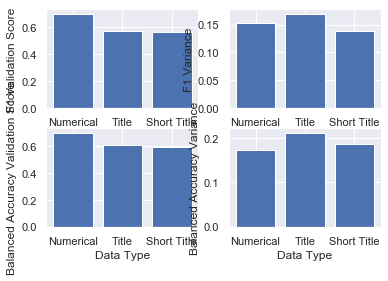

In [195]:
#plot the average performance of the model for each dataset and metric 
#plot the difference between the train and validation score
labels = ['Numerical', 'Title', 'Short Title']
f1_means = [np.mean(num_f1), np.mean(text_f1), np.mean(short_text_f1)]
f1_variance = [np.mean(num_train_f1) - np.mean(num_f1), np.mean(text_train_f1) - np.mean(text_f1),
               np.mean(short_text_train_f1) - np.mean(short_text_f1)]
accuracy_means = [np.mean(num_accuracy), np.mean(text_accuracy), np.mean(short_text_accuracy)]
accuracy_variance = [np.mean(num_train_accuracy) - np.mean(num_accuracy), np.mean(text_train_accuracy) - np.mean(text_accuracy), 
                     np.mean(short_text_train_accuracy) - np.mean(short_text_accuracy)]

ax1 = plt.subplot(221)
ax1.bar(labels, f1_means)
plt.xlabel('Data Type')
plt.ylabel('F1 Validation Score')

ax2 = plt.subplot(222)
ax2.bar(labels, f1_variance)
plt.xlabel('Data Type')
plt.ylabel('F1 Variance')

ax3 = plt.subplot(223)
ax3.bar(labels, accuracy_means)
plt.xlabel('Data Type')
plt.ylabel('Balanced Accuracy Validation Score')

ax4 = plt.subplot(224)
ax4.bar(labels, accuracy_variance)
plt.xlabel('Data Type')
plt.ylabel('Balanced Accuracy Variance')

plt.show()

In [196]:
#print the average performance for each stage
for i in range(4):
    print('Stage '+ str(i+1)+':')
    print()
    print('Numerical Train F1: ', np.mean(num_train_f1[i]))
    print('Numerical Test F1: ', np.mean(num_f1[i]))
    print('Title Train F1: ', np.mean(text_train_f1[i]))
    print('Title Test F1: ', np.mean(text_f1[i]))
    print('Short Title Train F1: ', np.mean(short_text_train_f1[i]))
    print('Short title Test F1: ', np.mean(short_text_f1[i]))
    print()
    print()

Stage 1:

Numerical Train F1:  0.6838899159017343
Numerical Test F1:  0.6317195925085418
Title Train F1:  0.27482326223544856
Title Test F1:  0.20063648151168803
Short Title Train F1:  0.2533440627253549
Short title Test F1:  0.1821754393828797


Stage 2:

Numerical Train F1:  0.8923917832023948
Numerical Test F1:  0.8048147411750722
Title Train F1:  0.8997104690317135
Title Test F1:  0.6932574662033494
Short Title Train F1:  0.8241693055276753
Short title Test F1:  0.6871217280425894


Stage 3:

Numerical Train F1:  0.8256567176372365
Numerical Test F1:  0.43434499297471074
Title Train F1:  0.7842098829640884
Title Test F1:  0.4666231602792113
Short Title Train F1:  0.7307310098561014
Short title Test F1:  0.49889563530215986


Stage 4:

Numerical Train F1:  0.9991316931982634
Numerical Test F1:  0.9173170247092486
Title Train F1:  0.9991308530368684
Title Test F1:  0.9198897346604904
Short Title Train F1:  0.9930877200257087
Short title Test F1:  0.8779444896040094




In [197]:
#train and evaluate the end to end model using gradient boosting
X = X_train_0
Y = np.ravel(y_train_0)
n = 500
gbm = GradientBoostingClassifier(learning_rate = 1/np.sqrt(n), n_estimators = n, random_state = 42)
cv = cross_validate(gbm, X, Y, cv = 5, scoring = 'f1', return_train_score = True)
train_score = np.mean(cv['train_score'])
train_std = np.std(cv['train_score'])
test_score = np.mean(cv['test_score'])
test_std = np.std(cv['test_score'])
print('Train Score Interval (95% Certainty): ', (train_score - 2*train_std, train_score + 2*train_std))
print('Validation Score Interval (95% Certainty): ', (test_score - 2*test_std, test_score + 2*test_std))

Train Score Interval (95% Certainty):  (0.2598113472229353, 0.3538502224138773)
Validation Score Interval (95% Certainty):  (-0.04641300805359673, 0.1565165436891529)


The Gradient Boosting Machine appears to have achieved better performance on the numerical data at the cost of increased overfitting. The machine has not been able to improve much upon the logistic regression performance on the text data, however, it has accomplished a reduced degree of overfitting. The same seems to hold true for the end-to-end model where validation performance is similar to the logistic regression model, but with a higher amount of spread and overfitting. During hyperparameter tuning, we will attempt to optimize the number of estimators and learning rate.

In [198]:
#fit the neural net model to each dataset using five fold cross validation and save the scores for each stage
neural_net = MLPClassifier(hidden_layer_sizes = (18,6), max_iter = 500)

num_f1 = []
num_train_f1 = []
num_accuracy = []
num_train_accuracy = []

text_f1 = []
text_train_f1 = []
text_accuracy = []
text_train_accuracy = []

short_text_f1 = []
short_text_train_f1 = []
short_text_accuracy = []
short_text_train_accuracy = []

for i in range(4):
    X1 = X_num['train'+str(i+1)]
    X2 = X_text['train'+str(i+1)]
    X3 = X_text['short_train'+str(i+1)]
    Y = np.ravel(y['train'+str(i+1)])
    
    cv1 = cross_validate(neural_net, X1, Y, scoring = metrics, cv = 5, return_train_score = True)
    cv2 = cross_validate(neural_net, X2, Y, scoring = metrics, cv = 5, return_train_score = True)
    cv3 = cross_validate(neural_net, X3, Y, scoring = metrics, cv = 5, return_train_score = True)
    
    num_f1.append(cv1['test_f1'])
    num_train_f1.append(cv1['train_f1'])
    num_accuracy.append(cv1['test_balanced_accuracy'])
    num_train_accuracy.append(cv1['train_balanced_accuracy'])
    
    text_f1.append(cv2['test_f1'])
    text_train_f1.append(cv2['train_f1'])
    text_accuracy.append(cv2['test_balanced_accuracy'])
    text_train_accuracy.append(cv2['train_balanced_accuracy'])
    
    short_text_f1.append(cv3['test_f1'])
    short_text_train_f1.append(cv3['train_f1'])
    short_text_accuracy.append(cv3['test_balanced_accuracy'])
    short_text_train_accuracy.append(cv3['train_balanced_accuracy'])
    

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't co

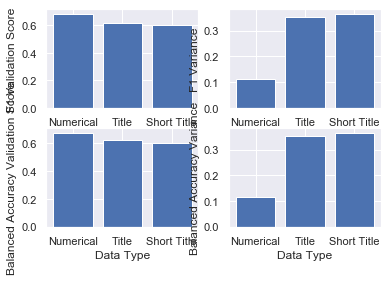

In [199]:
#plot the average performance of the model for each dataset and metric 
#plot the difference between the train and validation score
labels = ['Numerical', 'Title', 'Short Title']
f1_means = [np.mean(num_f1), np.mean(text_f1), np.mean(short_text_f1)]
f1_variance = [np.mean(num_train_f1) - np.mean(num_f1), np.mean(text_train_f1) - np.mean(text_f1),
               np.mean(short_text_train_f1) - np.mean(short_text_f1)]
accuracy_means = [np.mean(num_accuracy), np.mean(text_accuracy), np.mean(short_text_accuracy)]
accuracy_variance = [np.mean(num_train_accuracy) - np.mean(num_accuracy), np.mean(text_train_accuracy) - np.mean(text_accuracy), 
                     np.mean(short_text_train_accuracy) - np.mean(short_text_accuracy)]

ax1 = plt.subplot(221)
ax1.bar(labels, f1_means)
plt.xlabel('Data Type')
plt.ylabel('F1 Validation Score')

ax2 = plt.subplot(222)
ax2.bar(labels, f1_variance)
plt.xlabel('Data Type')
plt.ylabel('F1 Variance')

ax3 = plt.subplot(223)
ax3.bar(labels, accuracy_means)
plt.xlabel('Data Type')
plt.ylabel('Balanced Accuracy Validation Score')

ax4 = plt.subplot(224)
ax4.bar(labels, accuracy_variance)
plt.xlabel('Data Type')
plt.ylabel('Balanced Accuracy Variance')

plt.show()

In [200]:
#print the average performance for each stage
for i in range(4):
    print('Stage '+ str(i+1)+':')
    print()
    print('Numerical Train F1: ', np.mean(num_train_f1[i]))
    print('Numerical Test F1: ', np.mean(num_f1[i]))
    print('Title Train F1: ', np.mean(text_train_f1[i]))
    print('Title Test F1: ', np.mean(text_f1[i]))
    print('Short Title Train F1: ', np.mean(short_text_train_f1[i]))
    print('Short title Test F1: ', np.mean(short_text_f1[i]))
    print()
    print()

Stage 1:

Numerical Train F1:  0.6700128016651495
Numerical Test F1:  0.6285522451001999
Title Train F1:  0.9145043083231243
Title Test F1:  0.3798091074421723
Short Title Train F1:  0.9388025227038146
Short title Test F1:  0.3798029506655186


Stage 2:

Numerical Train F1:  0.849731520334306
Numerical Test F1:  0.7740686189963921
Title Train F1:  0.9833072565124172
Title Test F1:  0.6803113369323145
Short Title Train F1:  0.9785431364055694
Short title Test F1:  0.6472303856607293


Stage 3:

Numerical Train F1:  0.6968854649998346
Numerical Test F1:  0.4124512233698717
Title Train F1:  0.9639658135578939
Title Test F1:  0.4988376535735582
Short Title Train F1:  0.9588646317303782
Short title Test F1:  0.5271589123755543


Stage 4:

Numerical Train F1:  0.9576410976092624
Numerical Test F1:  0.9081604349094364
Title Train F1:  0.9991300128754734
Title Test F1:  0.8890040731814552
Short Title Train F1:  0.993357998716578
Short title Test F1:  0.8573980130852039




In [201]:
#train and evaluate the end to end model using neural network
X = X_train_0
Y = np.ravel(y_train_0)
neural_net = MLPClassifier(hidden_layer_sizes = (18,6), max_iter = 500)
cv = cross_validate(neural_net, X, Y, cv = 5, scoring = 'f1', return_train_score = True)
train_score = np.mean(cv['train_score'])
train_std = np.std(cv['train_score'])
test_score = np.mean(cv['test_score'])
test_std = np.std(cv['test_score'])
print('Train Score Interval (95% Certainty): ', (train_score - 2*train_std, train_score + 2*train_std))
print('Validation Score Interval (95% Certainty): ', (test_score - 2*test_std, test_score + 2*test_std))

Train Score Interval (95% Certainty):  (-0.010929097333073446, 0.024008310092414154)
Validation Score Interval (95% Certainty):  (0.0, 0.0)


Although the neural network was not able to reach convergence in 500 iterations for any of the stages, the severe degree of overfitting suggests that a model with this complexity level is not optimal for our data. During hyperparameter tuning, we will attempt to fit a MLP with a single hidden layer to the data to see how this affects the overfitting.

For all three of the above models, the F1 score and Balanced Accuracy showed nearly identical trends. Therefore, moving forward, we will limit our evaluation metrics to just the F1 score for the samke of simplicity and ease of comparison.

#### 4. Hyperparameter Tuning

In [169]:
#fit a logistic regression model to the stage 4 short titles dataset using 25-250 dimensions
scores = []
train_scores = []
explained_variance = []
log_reg = LogisticRegression(class_weight = 'balanced', max_iter = 1000)
for dim in np.arange(25,275,25):
    svd = TruncatedSVD(dim)
    svd.fit(X_text['short_train4'])
    explained_variance.append(sum(svd.explained_variance_ratio_))
    X = svd.transform(X_text['short_train4'])
    Y = np.ravel(y['train4'])
    cv = cross_validate(gbm, X, Y, scoring = 'f1', return_train_score = True)
    scores.append(cv['test_score'])
    train_scores.append(cv['train_score'])

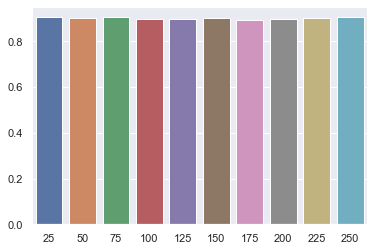

In [170]:
#plot model performance on the smallest text dataset
sns.barplot(np.arange(25,275,25), np.mean(scores, axis = 1))

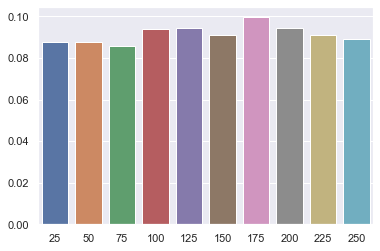

In [171]:
#plot overfitting on the smallest text dataset
sns.barplot(np.arange(25,275,25), np.mean(train_scores, axis = 1) - np.mean(scores, axis = 1))

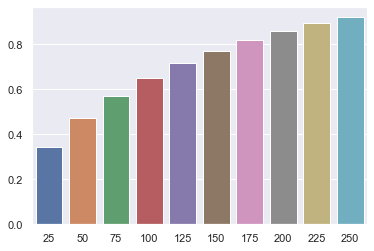

In [172]:
#plot total explained variance on the samllest text dataset
sns.barplot(np.arange(25,275,25), explained_variance)

In [165]:
#fit a logistic regression model to the stage 1 titles dataset using 25-250 dimensions
scores = []
train_scores = []
explained_variance = []
log_reg = LogisticRegression(class_weight = 'balanced', max_iter = 1000)
for dim in np.arange(25,275,25):
    svd = TruncatedSVD(dim)
    svd.fit(X_text['train1'])
    explained_variance.append(sum(svd.explained_variance_ratio_))
    X = svd.transform(X_text['train1'])
    Y = np.ravel(y['train1'])
    cv = cross_validate(gbm, X, Y, scoring = 'f1', return_train_score = True)
    scores.append(cv['test_score'])
    train_scores.append(cv['train_score'])

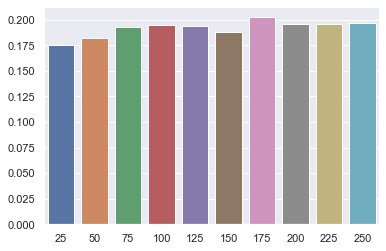

In [166]:
#plot model performance on the largest text dataset
sns.barplot(np.arange(25,275,25), np.mean(scores, axis = 1))

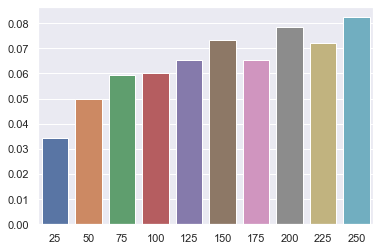

In [167]:
#plot model overfitting on the largest text dataset
sns.barplot(np.arange(25,275,25), np.mean(train_scores, axis = 1) - np.mean(scores, axis = 1))

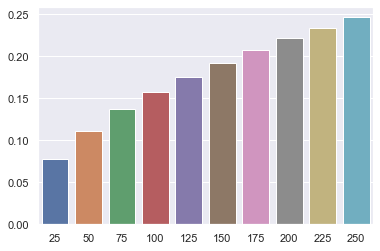

In [168]:
#plot total explained varaince on the largest text dataset
sns.barplot(np.arange(25,275,25), explained_variance)

From the two extreme cases above (smallest text dataset and largest) it becomes apparent that the number of features has very little impact on the performance of the model, although it has a significant impact on the level of overfitting. This tells us that most of the predictive power of the text data comes from the first few dimensions encoded in PCA while the remaining hundreds or thousands of dimensions are mostly noise.

Because the performance on the most complex text data is much lower using PCA than using the raw vectorized data, we will forgo PCA and simply fit the Logistic Regressor to the unsimplified data at the rist of some overfitting. We will only be using Logistic Regression for the text data because it achieves comparable results to the more complex models in much less time.

In [220]:
scores = []
train_scores = []
for n in np.arange(50,625,50):
    
    X = X_num['train1']
    Y = np.ravel(y['train1'])
    gbm = GradientBoostingClassifier(learning_rate = 1/np.sqrt(n), n_estimators = n, random_state = 42)
    cv = cross_validate(gbm, X, Y, scoring = 'f1', cv = 5, return_train_score = True)
    scores.append(np.mean(cv['test_score']))
    train_scores.append(np.mean(cv['train_score']))

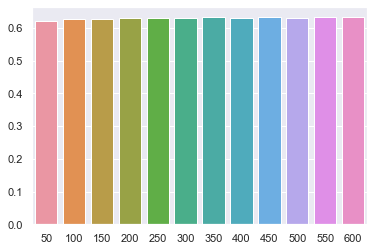

In [221]:
sns.barplot(np.arange(50,625,50),scores)

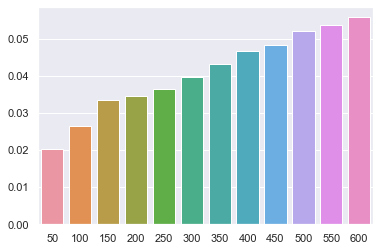

In [222]:
sns.barplot(np.arange(50,625,50), np.array(train_scores) - np.array(scores))

From the graphs above it is apparent that the number of classifiers has very little impact on the performance of our Gradient Boosting Machine, while significantly raising the level of overfitting. As a result we will use only 100 estimators for our model to ensure convergence without too much overfitting.

In [226]:
scores = []
train_scores = []
for n in range(1,28):
    X = X_num['train1']
    Y = np.ravel(y['train1'])
    neural_net = MLPClassifier(hidden_layer_sizes = (n,), max_iter = 500)
    cv = cross_validate(neural_net, X, Y, scoring = 'f1', cv = 5, return_train_score = True)
    scores.append(np.mean(cv['test_score']))
    train_scores.append(np.mean(cv['train_score']))

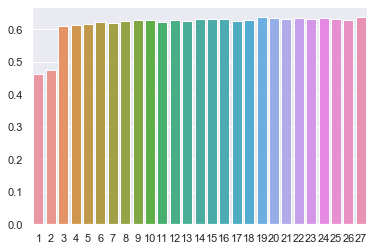

In [228]:
sns.barplot(np.arange(1,28),scores)

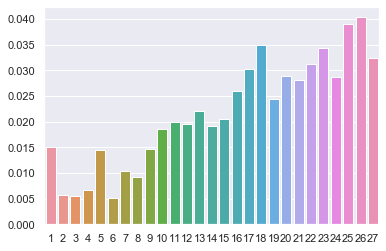

In [229]:
sns.barplot(np.arange(1,28), np.array(train_scores) - np.array(scores))

3 neurons in the first layer seems to yield comparable performance to an larger number of neurons while also minimizing overfitting. We will now examine the added benefit of a second layer.

In [251]:
scores = []
train_scores = []
for n in range(1,9):
    X = X_num['train1']
    Y = np.ravel(y['train1'])
    neural_net = MLPClassifier(hidden_layer_sizes = (3,n), max_iter = 500)
    cv = cross_validate(neural_net, X, Y, scoring = 'f1', cv = 5, return_train_score = True)
    scores.append(np.mean(cv['test_score']))
    train_scores.append(np.mean(cv['train_score']))

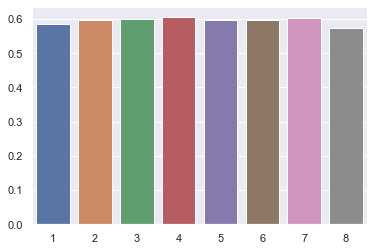

In [252]:
sns.barplot(np.arange(1,9),scores)

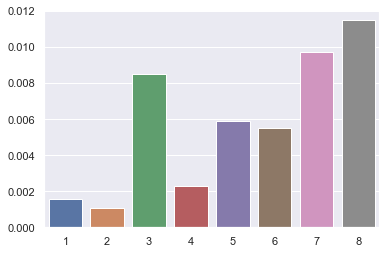

In [253]:
sns.barplot(np.arange(1,9), np.array(train_scores) - np.array(scores))

4 neurons in the second layer appears to achieve optimal performance and even decreases the level of overfitting from the single layer model. We will now examine the benefit of a third layer.

In [254]:
scores = []
train_scores = []
for n in range(1,9):
    X = X_num['train1']
    Y = np.ravel(y['train1'])
    neural_net = MLPClassifier(hidden_layer_sizes = (3,4,n), max_iter = 500)
    cv = cross_validate(neural_net, X, Y, scoring = 'f1', cv = 5, return_train_score = True)
    scores.append(np.mean(cv['test_score']))
    train_scores.append(np.mean(cv['train_score']))

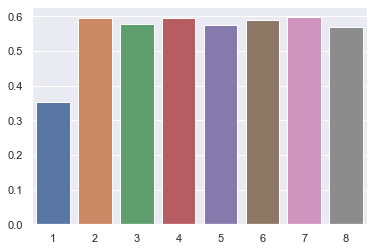

In [255]:
sns.barplot(np.arange(1,9),scores)

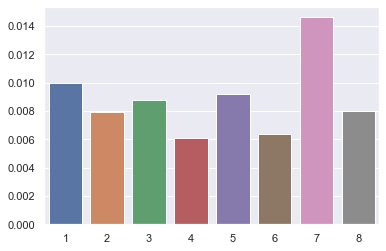

In [256]:
sns.barplot(np.arange(1,9), np.array(train_scores) - np.array(scores))

At this point it is clear that at the second layer, we had reached the point of diminishing marginal returns. Now, when considering a third layer, we see that any numer of neurons will raise the level of overfitting and decrease performance. Therefore, for our model we will utilize a Neural Network with 2 hidden layers of size 3 and 4 respectively.

### 5. Ensemble

We will now examine the added benefit of combining our models into an ensemble using both a simple average and a Decision Tree

In [271]:
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier

In [283]:
tree_scores = []
train_scores = []
test_scores = []
train_predictions = {}
test_predictions = {}
for i in range(4):
    tree = DecisionTreeClassifier()
    
    train_df = pd.DataFrame()
    
    test_df = pd.DataFrame()
    
    log_reg_titles = LogisticRegression(class_weight = 'balanced', max_iter = 1000)
    log_reg_short_titles = LogisticRegression(class_weight = 'balanced', max_iter = 1000)
    log_reg_num = LogisticRegression(class_weight = 'balanced', max_iter = 1000)
    gbm = GradientBoostingClassifier(learning_rate = 0.1, n_estimators = 100, random_state = 42)
    nn = MLPClassifier(hidden_layer_sizes = (3,4), max_iter = 1000)

    log_reg_titles.fit(X_text['train'+str(i+1)], np.ravel(y['train'+str(i+1)]))
    train_df['titles'] = log_reg_titles.predict_proba(X_text['train'+str(i+1)])[:,1]
    test_df['titles'] = log_reg_titles.predict_proba(X_text['test'+str(i+1)])[:,1]

    log_reg_short_titles.fit(X_text['short_train'+str(i+1)], np.ravel(y['train'+str(i+1)]))
    train_df['short_titles'] = log_reg_short_titles.predict_proba(X_text['short_train'+str(i+1)])[:,1]
    test_df['short_titles'] = log_reg_short_titles.predict_proba(X_text['short_test'+str(i+1)])[:,1]

    log_reg_num.fit(X_num['train'+str(i+1)], np.ravel(y['train'+str(i+1)]))
    train_df['log_reg'] = log_reg_num.predict_proba(X_num['train'+str(i+1)])[:,1]
    test_df['log_reg'] = log_reg_num.predict_proba(X_num['test'+str(i+1)])[:,1]

    gbm.fit(X_num['train'+str(i+1)], np.ravel(y['train'+str(i+1)]))
    train_df['gbm'] = gbm.predict_proba(X_num['train'+str(i+1)])[:,1]
    test_df['gbm'] = gbm.predict_proba(X_num['test'+str(i+1)])[:,1]

    nn.fit(X_num['train'+str(i+1)], np.ravel(y['train'+str(i+1)]))
    train_df['nn'] = nn.predict_proba(X_num['train'+str(i+1)])[:,1]
    test_df['nn'] = nn.predict_proba(X_num['test'+str(i+1)])[:,1]

    train_df['average'] = train_df.mean(axis = 1)
    test_df['average'] = test_df.mean(axis = 1)

    train_df['predictions'] = round(train_df['average'])
    test_df['predictions'] = round(test_df['average'])

    train_df['target'] = y['train'+str(i+1)]
    test_df['target'] = y['test'+str(i+1)]
    
    train_scores.append(f1_score(train_df.target, train_df.predictions))
    test_scores.append(f1_score(test_df.target, test_df.predictions))
    
    train_predictions[str(i+1)] = train_df['predictions']
    test_predictions[str(i+1)] = test_df['predictions']
    
    tree.fit(train_df[['titles', 'short_titles', 'log_reg', 'gbm', 'nn']], np.ravel(y['train'+str(i+1)]))
    test_df['tree'] = tree.predict(test_df[['titles', 'short_titles', 'log_reg', 'gbm', 'nn']])
    tree_scores.append(f1_score(test_df.target, test_df.tree))
    

In [284]:
print('Train Scores: ')
print(train_scores)

Train Scores: 
[0.7496402877697841, 0.868144690781797, 0.7212336892052195, 0.9826187717265353]


In [285]:
print('Test Scores: ')
print(test_scores)

Test Scores: 
[0.6725274725274726, 0.7972027972027973, 0.5125628140703519, 0.9369369369369369]


In [286]:
print('Tree Scores: ')
print(tree_scores)

Experiment: 
[0.6542655548428481, 0.7603305785123966, 0.49107142857142855, 0.9162995594713658]


While there is certainly some overfitting, the average ensemble model produced higher test scores than any of the baseline models were able to accomplish during cross validation- where they were testing on data scaled and vecotrized with the training data, and so could be expected to perform worse on completely unseen data. While the decision tree ensemble also made an improvement over the solo models, the average ensemble performed better on each stage and required much less computation power.